In [105]:
import pandas as pd
import numpy as np
import pylab
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, recall_score, precision_score

from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.decomposition import FactorAnalysis

In [106]:
dataset = pd.read_csv('wdbc_data.csv')
dataset = dataset.drop(['id'], axis = 1)
dataset.diagnosis.replace(to_replace = dict(M = 1, B = 0), inplace = True)
dataset.sample(10)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
236,1,23.210,26.97,153.50,1670.0,0.09509,0.16820,0.19500,0.12370,0.1909,...,31.01,34.51,206.00,2944.0,0.14810,0.41260,0.5820,0.25930,0.3103,0.08677
63,0,9.173,13.86,59.20,260.9,0.07721,0.08751,0.05988,0.02180,0.2341,...,10.01,19.23,65.59,310.1,0.09836,0.16780,0.1397,0.05087,0.3282,0.08490
414,1,15.130,29.81,96.71,719.5,0.08320,0.04605,0.04686,0.02739,0.1852,...,17.26,36.91,110.10,931.4,0.11480,0.09866,0.1547,0.06575,0.3233,0.06165
22,1,15.340,14.26,102.50,704.4,0.10730,0.21350,0.20770,0.09756,0.2521,...,18.07,19.08,125.10,980.9,0.13900,0.59540,0.6305,0.23930,0.4667,0.09946
373,1,20.640,17.35,134.80,1335.0,0.09446,0.10760,0.15270,0.08941,0.1571,...,25.37,23.17,166.80,1946.0,0.15620,0.30550,0.4159,0.21120,0.2689,0.07055
127,1,19.000,18.91,123.40,1138.0,0.08217,0.08028,0.09271,0.05627,0.1946,...,22.32,25.73,148.20,1538.0,0.10210,0.22640,0.3207,0.12180,0.2841,0.06541
533,1,20.470,20.67,134.70,1299.0,0.09156,0.13130,0.15230,0.10150,0.2166,...,23.23,27.15,152.00,1645.0,0.10970,0.25340,0.3092,0.16130,0.3220,0.06386
9,1,12.460,24.04,83.97,475.9,0.11860,0.23960,0.22730,0.08543,0.2030,...,15.09,40.68,97.65,711.4,0.18530,1.05800,1.1050,0.22100,0.4366,0.20750
12,1,19.170,24.80,132.40,1123.0,0.09740,0.24580,0.20650,0.11180,0.2397,...,20.96,29.94,151.70,1332.0,0.10370,0.39030,0.3639,0.17670,0.3176,0.10230
41,1,10.950,21.35,71.90,371.1,0.12270,0.12180,0.10440,0.05669,0.1895,...,12.84,35.34,87.22,514.0,0.19090,0.26980,0.4023,0.14240,0.2964,0.09606


In [107]:
features = list(dataset.columns[1:])
features

['radius_mean',
 'texture_mean',
 'perimeter_mean',
 'area_mean',
 'smoothness_mean',
 'compactness_mean',
 'concavity_mean',
 'concave_points_mean',
 'symmetry_mean',
 'fractal_dimension_mean',
 'radius_se',
 'texture_se',
 'perimeter_se',
 'area_se',
 'smoothness_se',
 'compactness_se',
 'concavity_se',
 'concave_points_se',
 'symmetry_se',
 'fractal_dimension_se',
 'radius_worst',
 'texture_worst',
 'perimeter_worst',
 'area_worst',
 'smoothness_worst',
 'compactness_worst',
 'concavity_worst',
 'concave_points_worst',
 'symmetry_worst',
 'fractal_dimension_worst']

In [108]:
def build_model(classifier_fn, 
                name_of_y_col, 
                names_of_X_cols, 
                dataset, 
                *hyperparameters):
    
    X = dataset[names_of_X_cols]
    Y = dataset[name_of_y_col]
    
    fa_obj, X = do_factor_analysis(X, Y, *hyperparameters)
    
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3)
    
    model = classifier_fn(x_train, y_train)
    
    y_pred = model.predict(x_test)
    
    pred_results = pd.DataFrame({'y_test': y_test,
                               'y_pred': y_pred})
    
    model_crosstab = pd.crosstab(pred_results.y_pred, pred_results.y_test)
    
    acc = accuracy_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    
    return{'fact_ana_obj': fa_obj,
           'transform_x': X,
           'Accuracy': acc,
           'Precision': pre,
           'Recall': rec,
           'Confusion Matrix': model_crosstab
          }

In [109]:
def compare_results(result_dict):
    
    for key in result_dict:
        print('Test', key)
        print()
        print("Accuracy Score:", result_dict[key]['Accuracy'])
        print("Precision Score:", result_dict[key]['Precision'])
        print("Recall Score:", result_dict[key]['Recall'])
        print()

In [110]:
def visualize_results(result_dict):
    
    n_components = list(range(0, 30))
    acc = [result_dict[key]['Accuracy'] for key in result_dict]
    pre = [result_dict[key]['Precision'] for key in result_dict]
    rec = [result_dict[key]['Recall'] for key in result_dict]
    
    plt.figure(figsize = (12, 10))
    plt.plot(n_components, acc, label = 'Accuracy')
    plt.plot(n_components, pre, label = 'Precision')
    plt.plot(n_components, rec, label = 'Recall')
    
    pylab.ylim([0.7, 1.2])
    
    plt.xlabel('n_components')
    plt.ylabel('Score')
    
    plt.legend()

In [111]:
def do_factor_analysis(x, y, n):
    
    fact_ana = FactorAnalysis(n_components = n, random_state = 42, max_iter = 10000)
    x_new = fact_ana.fit_transform(x, y)
    
    return fact_ana, pd.DataFrame(x_new)

In [112]:
def logistic_fn(x_train, y_train):
    model = LogisticRegression(solver = 'liblinear')
    model.fit(x_train, y_train)
    
    return model

In [113]:
result_dict = {}

for i in range(1, 31):
    result_dict['n_components - ' + str(i)] = build_model(logistic_fn,
                                                          'diagnosis',
                                                          features,
                                                          dataset,
                                                          i)

In [114]:
compare_results(result_dict)

Test n_components - 1

Accuracy Score: 0.9005847953216374
Precision Score: 0.9019607843137255
Recall Score: 0.7931034482758621

Test n_components - 2

Accuracy Score: 0.9298245614035088
Precision Score: 0.9629629629629629
Recall Score: 0.8387096774193549

Test n_components - 3

Accuracy Score: 0.9239766081871345
Precision Score: 0.9508196721311475
Recall Score: 0.8529411764705882

Test n_components - 4

Accuracy Score: 0.9473684210526315
Precision Score: 0.9464285714285714
Recall Score: 0.8983050847457628

Test n_components - 5

Accuracy Score: 0.9649122807017544
Precision Score: 0.9830508474576272
Recall Score: 0.9206349206349206

Test n_components - 6

Accuracy Score: 0.9590643274853801
Precision Score: 0.9848484848484849
Recall Score: 0.9154929577464789

Test n_components - 7

Accuracy Score: 0.9532163742690059
Precision Score: 0.96875
Recall Score: 0.9117647058823529

Test n_components - 8

Accuracy Score: 0.9532163742690059
Precision Score: 0.9672131147540983
Recall Score: 0.90769

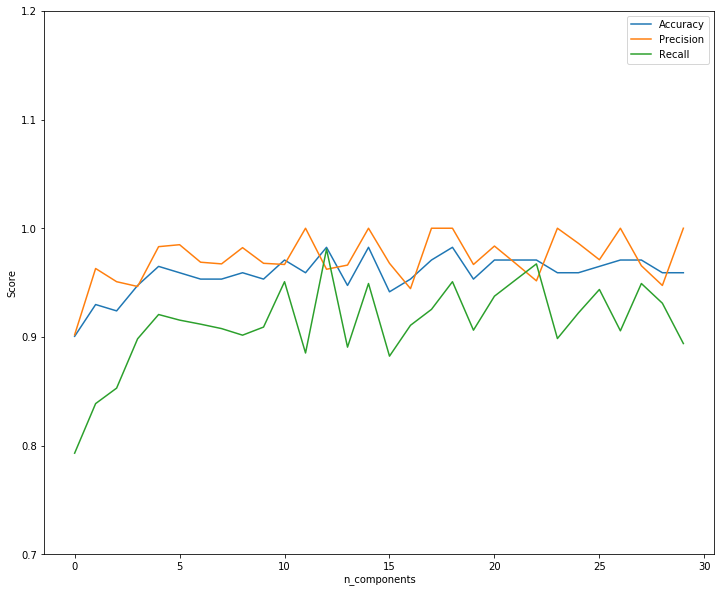

In [115]:
visualize_results(result_dict)

In [116]:
def rfc_fn(X_train, y_train):
    model = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=0)
    model.fit(X_train, y_train)
        
    return model

In [117]:
result_dict = {}

for i in range(1, 31):
    result_dict['n_components - ' + str(i)] = build_model(rfc_fn,
                                                          'diagnosis',
                                                          features,
                                                          dataset,
                                                          i)

In [118]:
compare_results(result_dict)

Test n_components - 1

Accuracy Score: 0.9064327485380117
Precision Score: 0.8813559322033898
Recall Score: 0.8524590163934426

Test n_components - 2

Accuracy Score: 0.9298245614035088
Precision Score: 0.9206349206349206
Recall Score: 0.8923076923076924

Test n_components - 3

Accuracy Score: 0.9122807017543859
Precision Score: 0.9322033898305084
Recall Score: 0.8333333333333334

Test n_components - 4

Accuracy Score: 0.9473684210526315
Precision Score: 0.9848484848484849
Recall Score: 0.8904109589041096

Test n_components - 5

Accuracy Score: 0.9766081871345029
Precision Score: 0.9552238805970149
Recall Score: 0.9846153846153847

Test n_components - 6

Accuracy Score: 0.9181286549707602
Precision Score: 0.8870967741935484
Recall Score: 0.8870967741935484

Test n_components - 7

Accuracy Score: 0.9473684210526315
Precision Score: 0.9545454545454546
Recall Score: 0.9130434782608695

Test n_components - 8

Accuracy Score: 0.9415204678362573
Precision Score: 0.9508196721311475
Recall Sco

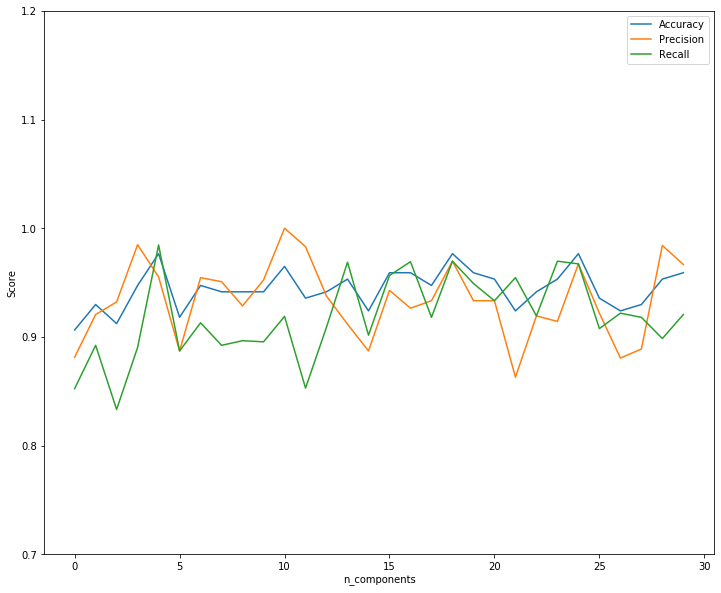

In [119]:
visualize_results(result_dict)

In [120]:
def stochastic_gradient_descent_fn(x_train, y_train, max_iter=10000, tol=1e-3):
    
    model = SGDClassifier(max_iter=max_iter, tol=tol)
    model.fit(x_train, y_train)
    
    return model

In [121]:
result_dict = {}

for i in range(1, 31):
    result_dict['n_components - ' + str(i)] = build_model(stochastic_gradient_descent_fn,
                                                          'diagnosis',
                                                          features,
                                                          dataset,
                                                          i)

In [122]:
compare_results(result_dict)

Test n_components - 1

Accuracy Score: 0.9415204678362573
Precision Score: 0.967741935483871
Recall Score: 0.8823529411764706

Test n_components - 2

Accuracy Score: 0.9707602339181286
Precision Score: 0.9836065573770492
Recall Score: 0.9375

Test n_components - 3

Accuracy Score: 0.9298245614035088
Precision Score: 0.9833333333333333
Recall Score: 0.8428571428571429

Test n_components - 4

Accuracy Score: 0.935672514619883
Precision Score: 0.9516129032258065
Recall Score: 0.8805970149253731

Test n_components - 5

Accuracy Score: 0.9649122807017544
Precision Score: 0.9384615384615385
Recall Score: 0.9682539682539683

Test n_components - 6

Accuracy Score: 0.9298245614035088
Precision Score: 0.9649122807017544
Recall Score: 0.8461538461538461

Test n_components - 7

Accuracy Score: 0.935672514619883
Precision Score: 0.9615384615384616
Recall Score: 0.847457627118644

Test n_components - 8

Accuracy Score: 0.9532163742690059
Precision Score: 0.90625
Recall Score: 0.9666666666666667

Tes

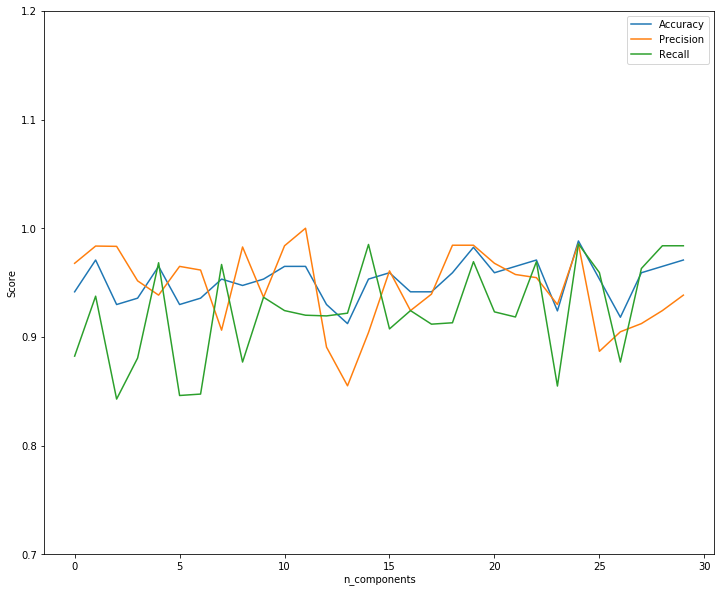

In [123]:
visualize_results(result_dict)

In [124]:
def svm_fn(x_train, y_train):
    model = SVC(kernel = 'linear')
    model.fit(x_train, y_train)
    
    return model

In [125]:
result_dict = {}

for i in range(1, 31):
    result_dict['n_components - ' + str(i)] = build_model(svm_fn,
                                                          'diagnosis',
                                                          features,
                                                          dataset,
                                                          i)

In [126]:
compare_results(result_dict)

Test n_components - 1

Accuracy Score: 0.9239766081871345
Precision Score: 0.9344262295081968
Recall Score: 0.8636363636363636

Test n_components - 2

Accuracy Score: 0.9239766081871345
Precision Score: 0.9666666666666667
Recall Score: 0.8405797101449275

Test n_components - 3

Accuracy Score: 0.9649122807017544
Precision Score: 1.0
Recall Score: 0.9047619047619048

Test n_components - 4

Accuracy Score: 0.9532163742690059
Precision Score: 0.9516129032258065
Recall Score: 0.921875

Test n_components - 5

Accuracy Score: 0.9707602339181286
Precision Score: 0.9855072463768116
Recall Score: 0.9444444444444444

Test n_components - 6

Accuracy Score: 0.9590643274853801
Precision Score: 1.0
Recall Score: 0.9

Test n_components - 7

Accuracy Score: 0.9649122807017544
Precision Score: 0.9846153846153847
Recall Score: 0.927536231884058

Test n_components - 8

Accuracy Score: 1.0
Precision Score: 1.0
Recall Score: 1.0

Test n_components - 9

Accuracy Score: 0.9766081871345029
Precision Score: 0.

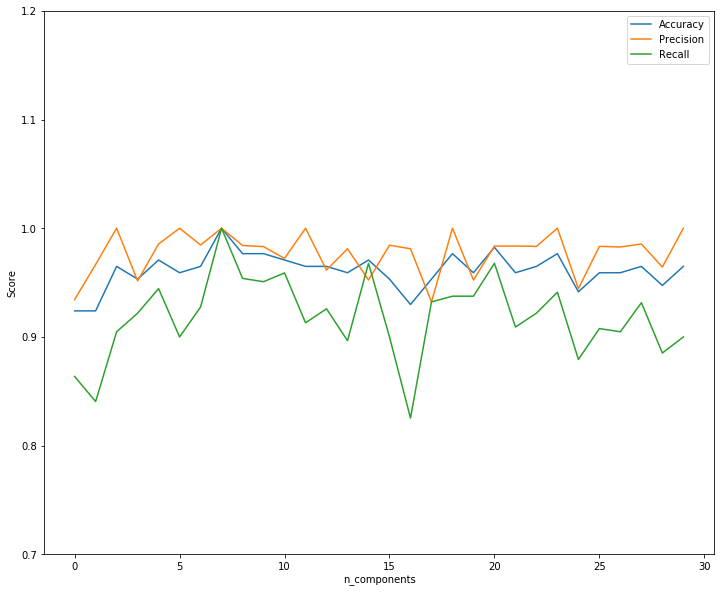

In [127]:
visualize_results(result_dict)

In [128]:
def KNN_fn(x_train, y_train):
    model = KNeighborsClassifier()
    model.fit(x_train, y_train)
    
    return model

In [129]:
result_dict = {}

for i in range(1, 31):
    result_dict['n_components - ' + str(i)] = build_model(KNN_fn,
                                                          'diagnosis',
                                                          features,
                                                          dataset,
                                                          i)

In [130]:
compare_results(result_dict)

Test n_components - 1

Accuracy Score: 0.8771929824561403
Precision Score: 0.9152542372881356
Recall Score: 0.7714285714285715

Test n_components - 2

Accuracy Score: 0.935672514619883
Precision Score: 0.9411764705882353
Recall Score: 0.8571428571428571

Test n_components - 3

Accuracy Score: 0.9122807017543859
Precision Score: 0.9833333333333333
Recall Score: 0.8082191780821918

Test n_components - 4

Accuracy Score: 0.9532163742690059
Precision Score: 0.9636363636363636
Recall Score: 0.8983050847457628

Test n_components - 5

Accuracy Score: 0.9298245614035088
Precision Score: 0.9230769230769231
Recall Score: 0.8

Test n_components - 6

Accuracy Score: 0.9766081871345029
Precision Score: 1.0
Recall Score: 0.9375

Test n_components - 7

Accuracy Score: 0.9122807017543859
Precision Score: 1.0
Recall Score: 0.765625

Test n_components - 8

Accuracy Score: 0.935672514619883
Precision Score: 0.9411764705882353
Recall Score: 0.8571428571428571

Test n_components - 9

Accuracy Score: 0.9824

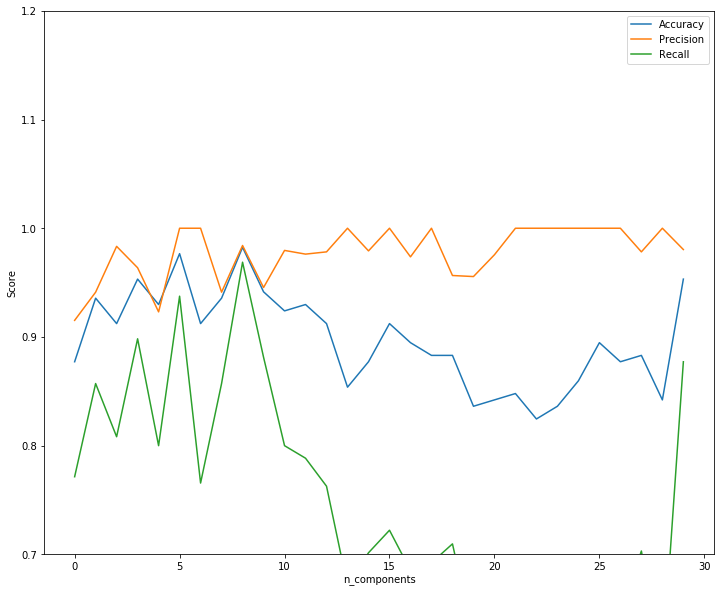

In [131]:
visualize_results(result_dict)

In [132]:
def DTC_fn(x_train, y_train):
    model = DecisionTreeClassifier()
    model.fit(x_train, y_train)
    
    return model

In [133]:
result_dict = {}

for i in range(1, 31):
    result_dict['n_components - ' + str(i)] = build_model(DTC_fn,
                                                          'diagnosis',
                                                          features,
                                                          dataset,
                                                          i)

In [134]:
compare_results(result_dict)

Test n_components - 1

Accuracy Score: 0.9122807017543859
Precision Score: 0.8928571428571429
Recall Score: 0.847457627118644

Test n_components - 2

Accuracy Score: 0.9181286549707602
Precision Score: 0.8793103448275862
Recall Score: 0.8793103448275862

Test n_components - 3

Accuracy Score: 0.9064327485380117
Precision Score: 0.890625
Recall Score: 0.8636363636363636

Test n_components - 4

Accuracy Score: 0.9415204678362573
Precision Score: 0.9122807017543859
Recall Score: 0.9122807017543859

Test n_components - 5

Accuracy Score: 0.9590643274853801
Precision Score: 0.9482758620689655
Recall Score: 0.9322033898305084

Test n_components - 6

Accuracy Score: 0.9590643274853801
Precision Score: 0.8947368421052632
Recall Score: 0.9807692307692307

Test n_components - 7

Accuracy Score: 0.9239766081871345
Precision Score: 0.9074074074074074
Recall Score: 0.8596491228070176

Test n_components - 8

Accuracy Score: 0.9415204678362573
Precision Score: 0.9298245614035088
Recall Score: 0.89830

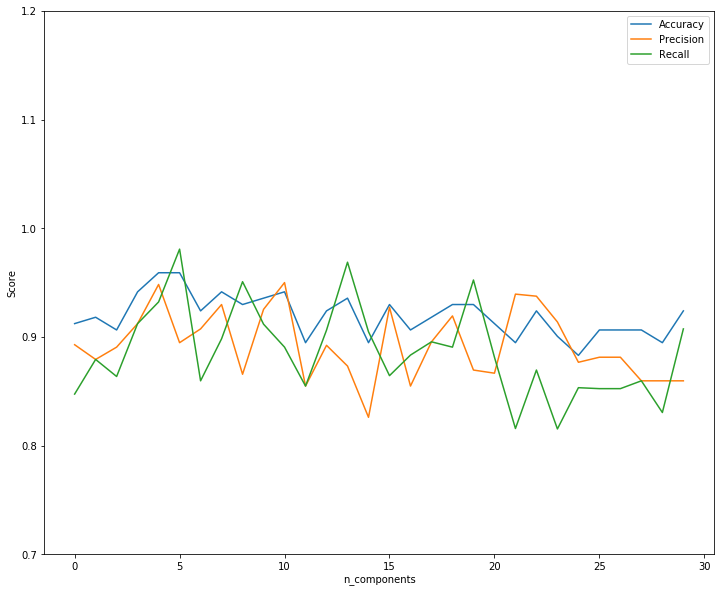

In [135]:
visualize_results(result_dict)

In [142]:
def ridge_fn(x_train, y_train):
    model = RidgeClassifier()
    model.fit(x_train, y_train)
    
    return model

In [143]:
result_dict = {}

for i in range(1, 31):
    result_dict['n_components - ' + str(i)] = build_model(ridge_fn,
                                                          'diagnosis',
                                                          features,
                                                          dataset,
                                                          i)

In [144]:
compare_results(result_dict)

Test n_components - 1

Accuracy Score: 0.8713450292397661
Precision Score: 0.9782608695652174
Recall Score: 0.6818181818181818

Test n_components - 2

Accuracy Score: 0.8538011695906432
Precision Score: 1.0
Recall Score: 0.6268656716417911

Test n_components - 3

Accuracy Score: 0.8362573099415205
Precision Score: 1.0
Recall Score: 0.5555555555555556

Test n_components - 4

Accuracy Score: 0.9122807017543859
Precision Score: 1.0
Recall Score: 0.7887323943661971

Test n_components - 5

Accuracy Score: 0.9239766081871345
Precision Score: 0.9803921568627451
Recall Score: 0.8064516129032258

Test n_components - 6

Accuracy Score: 0.9649122807017544
Precision Score: 0.9811320754716981
Recall Score: 0.9122807017543859

Test n_components - 7

Accuracy Score: 0.9298245614035088
Precision Score: 0.96
Recall Score: 0.8275862068965517

Test n_components - 8

Accuracy Score: 0.9532163742690059
Precision Score: 1.0
Recall Score: 0.8857142857142857

Test n_components - 9

Accuracy Score: 0.947368421

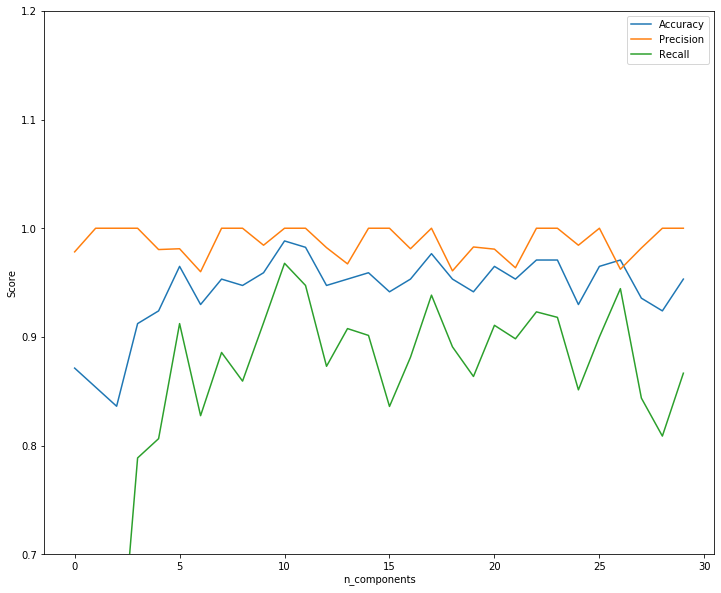

In [145]:
visualize_results(result_dict)

In [148]:
def GNB_fn(x_train, y_train):
    model = GaussianNB()
    model.fit(x_train, y_train)
    
    return model

In [149]:
result_dict = {}

for i in range(1, 31):
    result_dict['n_components - ' + str(i)] = build_model(GNB_fn,
                                                          'diagnosis',
                                                          features,
                                                          dataset,
                                                          i)

In [150]:
compare_results(result_dict)

Test n_components - 1

Accuracy Score: 0.8830409356725146
Precision Score: 1.0
Recall Score: 0.726027397260274

Test n_components - 2

Accuracy Score: 0.9122807017543859
Precision Score: 0.9245283018867925
Recall Score: 0.8166666666666667

Test n_components - 3

Accuracy Score: 0.8596491228070176
Precision Score: 0.864406779661017
Recall Score: 0.7611940298507462

Test n_components - 4

Accuracy Score: 0.9122807017543859
Precision Score: 0.8870967741935484
Recall Score: 0.873015873015873

Test n_components - 5

Accuracy Score: 0.9122807017543859
Precision Score: 0.8852459016393442
Recall Score: 0.8709677419354839

Test n_components - 6

Accuracy Score: 0.8830409356725146
Precision Score: 0.7966101694915254
Recall Score: 0.8545454545454545

Test n_components - 7

Accuracy Score: 0.8888888888888888
Precision Score: 0.8269230769230769
Recall Score: 0.8113207547169812

Test n_components - 8

Accuracy Score: 0.8830409356725146
Precision Score: 0.819672131147541
Recall Score: 0.8474576271186

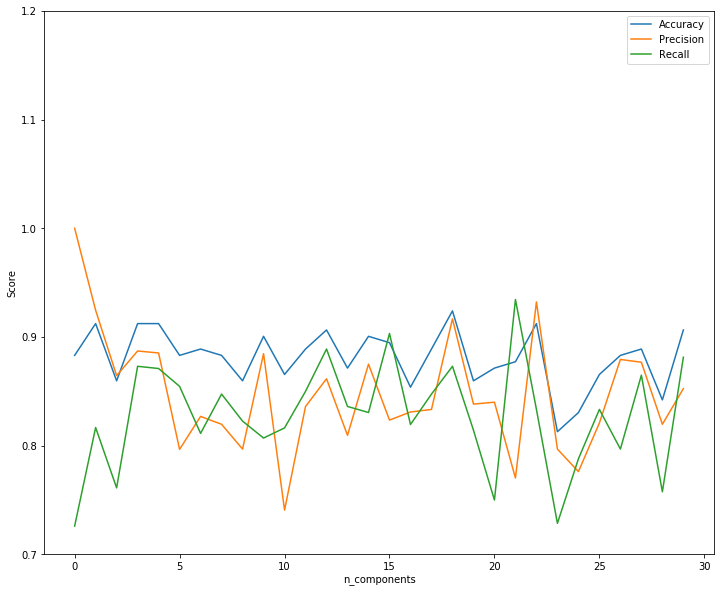

In [151]:
visualize_results(result_dict)